## Satellite image analysis with python
### What we will learn:
- How to understand the metadata of the satellite images
- How to read band images as numpy arrays
- How to show a satellite image with arbitrary combination of bands
- How to calculate NDVI values 
- How to write a geotiff file

We need to import some libraries to handle and show the satellite images in python. Jupyter notebook with Anaconda environment is strongly recommended. Anaconda contains a lot of useful packages not only satellite image analysis but also machine learning, data science, and so on. If you haven't insalled it yet, this videos is my recommendation to follow.

- Anaconda (Conda) for Python - What & Why? https://youtu.be/23aQdrS58e0

Before starting the import of the libraries, rasterio should be installed via conda or pip. My recommendation is to use conda, so go to the anaconda prompt, then write and execute the command as shown in the image. If the install ends successfully, you will be able to import it in python.

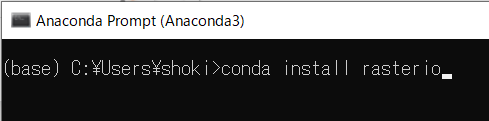

rasterio is the python package which helps us handle many kinds of GIS data. Gdal is another famous tool in GIS and remote sensing applications, but it has some drawbacks such as pointer management like the C language. Therefore, I will use rasterio as a main tool for the following introduction to satellite remote sensing analysis.

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt #Matplotlib is used to show images.

I made a geotiff file of the sentinel-2 level-2A product from Google Earth Engine. It contains 11 bands and is resampled to 20 m resolution. "sentinel2Image.tif" is the file name. Please make sure where you stored it.

To open a file with rasterio is very much simple. Only we need to do is to give a path to the file to rasterio. <br>
### **How to open a image with rasterio**: rasterio.open("path to the target file")

In [2]:
opened=rasterio.open("C:\\Users\shoki\Desktop\TargetFolder\sentinel2Image.tif")

Before we start to explore the satellite image, first we will look into the metadata of the file. Metadata are very much important because we need to know the data characteristics to appropriately handle them. To get metadata by using rasterio is also simple. Add ".meta" after the variavle name we created before.

In [3]:
opened.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 4587,
 'height': 2270,
 'count': 11,
 'crs': CRS.from_epsg(32654),
 'transform': Affine(20.0, 0.0, 315380.0,
        0.0, -20.0, 3967020.0)}

What is the meaning of those metadata? I'll give short explanations below.
- **'driver': 'GTiff'** : It means that the file is in a geotiff format.
- **'dtype': 'uint16'** : The data are written by using uint16 (unsigned integers with a 16 bits size). 
- **'nodata': None** : There is no specification of nodata values.
- **'width': 4587** : It has 4587 columns.
- **'height': 2270** : It has 2270 rows.
- **'count': 11** : It consists of 11 bands.
- **'crs': CRS.from_epsg(32654)** : It is projected in UTM zone 54 with WGS84 as the ellipsoid. EPSG code is a handy way of specifing the coordinate reference system (CRS) of the product. Another famous epsg code is epsg=4326 which corresponds to the usual lat/long system with WGS84 as the ellipsoid.
- **'transform': Affine(20.0, 0.0, 315380.0, 0.0, -20.0, 3967020.0)** : This is the affine trasformation of the image. 

Let's check what bands inside the file are. To see the name of the bands, add ".descriptions".

In [4]:
opened.descriptions

('B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12')

The detailed sentinel-2 band description can be found [here](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/msi-instrument). Brief descriptions of the bands are given below.


Band name | Original resolution | General name of the wavelength
- **B2** | 10 m | Blue
- **B3** | 10 m | Green
- **B4** | 10 m | Red
- **B5** | 20 m | Near infrared (NIR)
- **B6** | 20 m | Near infrared (NIR)
- **B7** | 20 m | Near infrared (NIR)
- **B8** | 10 m | Near infrared (NIR)
- **B8A** | 20 m | Near infrared (NIR)
- **B9** | 20 m | Near infrared (NIR)
- **B11** | 20 m | Short wave infrared (SWIR)
- **B12** | 20 m | Short wave infrared (SWIR)

Next, we'll read each band as a numpy array. The values stored in the file are not the true surface reflectance. Therefore, we need to multiply a scale factor of 0.0001. The scale factor of the Sentinel-2 level-2A products in Google Earth Engine is provided [here](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR). Scale factors differ from products to products, so careful check of the description is needed.  

Rasterio **doesn't count bands from 0 unlike python**. Therefore, the natural position of the band within the product is used to specify the band to be read.

In [5]:
red=opened.read(3)*0.0001 #Read the third band ("B4")

In [6]:
green=opened.read(2)*0.0001 #Read the second band ("B3")

In [7]:
blue=opened.read(1)*0.0001 #Read the first band ("B2")

In [8]:
nir=opened.read(7)*0.0001 #Read the seventh band ("B8")

In [9]:
factor=3*np.mean(red) #This is a factor to modify the image appearance. The original image is too dark to see.

In [10]:
trueColor = np.dstack((red,green,blue))/factor #Store the numpy arrays into another numpy array.

In [11]:
trueColor.shape #trueColor array consists of three different arrays.

(2270, 4587, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


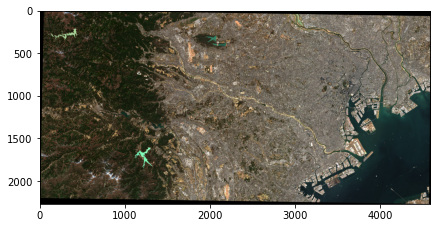

In [22]:
#Show the image.
plt.figure(figsize=(7, 7))
plt.imshow(trueColor)



We can change the combination of bands depending on our purposes. If we want to see the distribution of vegetaion, the false-color composite is useful. In the false-color composite, the near-infrared band, the red band, and the green band are used for red, green, and blue, respectively. Vegetations reflect the near-inrared spectrum strongly, so they appear red in the image. Other band combinations can be found [here](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/composites/).

In [13]:
falseColor = np.dstack((nir,red,green))/factor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


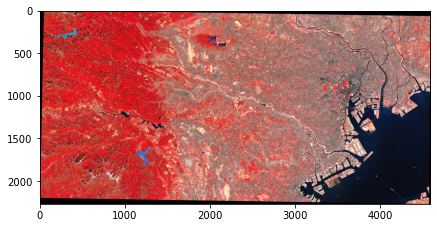

In [23]:
plt.figure(figsize=(7, 7))
plt.imshow(falseColor)

Normalized difference vegetation index (NDVI) is one of the most famous indices of remote sensing science. It takes advantage of the reflectance characteristics of vegetation. Vegetations show high-NDVI values so it'll be easier to differentiate them from the surrounding environment. A detailed explanation can be found [here](https://earthobservatory.nasa.gov/features/MeasuringVegetation/measuring_vegetation_2.php#:~:text=NDVI%20is%20calculated%20from%20the,and%20less%20near%2Dinfrared%20light.)

In [15]:
#Calculate NDVI. Some areas outside the image have zero values, so python may show a warning message.
ndvi = (nir-red)/(nir+red) 

C:\Users\shoki\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


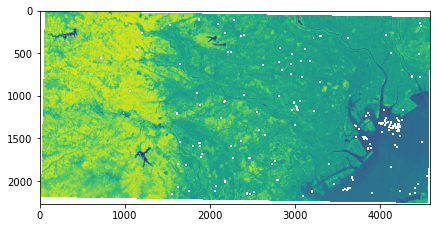

In [24]:
plt.figure(figsize=(7, 7))
plt.imshow(ndvi)

We can use a thresholding value to get possible vegetation pixels. To do so, an inequality condition can be applied to the numpy array of NDVI. If we use an inequality on numpy arrays, each component of the array has a boolean value that corresponds to the result of the condition. If the value is larger than the specified value, it has True. 

In [17]:
possibleVegetations=ndvi>0.4 #The thresholding value of 0.4 is used.

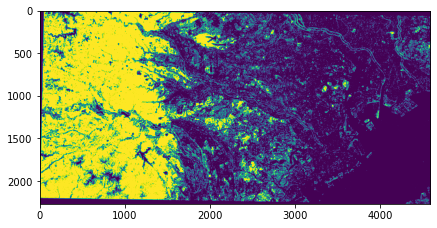

In [25]:
plt.figure(figsize=(7, 7))
plt.imshow(possibleVegetations)

The NDVI image is only a numpy array, so it can't be combined with another GIS data. Therefore, we'll export it as a geotiff file. rasterio gives us an easy way to do that job. The metadata required for the output file can be read from the source product.

In [19]:
outputPath="C:\\Users\shoki\Desktop\TargetFolder" #The path to the folder which we want to store the output.
fileName="\\NDVI.tif" #The file name of the output.

driver=opened.meta["driver"]
width=opened.meta["width"]
height=opened.meta["height"]
count=opened.meta["count"]
crs=opened.meta["crs"]
transform=opened.meta["transform"]
dtype=ndvi.dtype 

with rasterio.open(outputPath+fileName,
                   'w',
                  driver=driver,
                  width=width,
                  height=height,
                  count=count,
                  crs=crs,
                  transform=transform,
                  dtype=dtype) as output:
    output.write(ndvi,1) #Write the ndvi array as the first band of the image.
    output.close()

There is a newly created file inside the target folder!

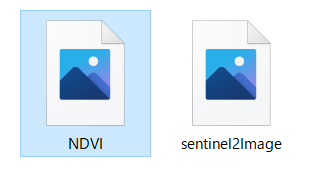

Let's read and see whether the output image is OK or not.

In [20]:
opened_NDVI_array=rasterio.open(outputPath+fileName).read(1)

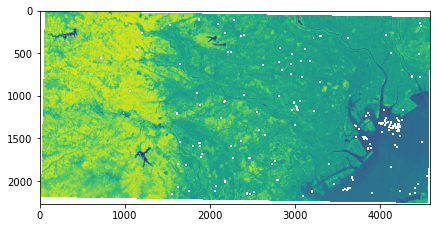

In [26]:
plt.figure(figsize=(7, 7))
plt.imshow(opened_NDVI_array)

The image looks same as before! The output image was correctly exported as a geotiff file, so we can use it with any other GIS products.
#### In the next tutorial, we'll learn some optional operations of handling satellite images.